# Определение перспективного тарифа для телеком-компании

**Дано:** компания «Мегалайн», федеральный оператор сотовой связи, предлагает клиентам два тарифных плана: «Смарт» и «Ультра».
<br>Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Задача:** сделать предварительный анализ тарифов на небольшой выборке клиентов, чтобы понять, какой тариф приносит больше денег.

**План исследования:**
 1. Обзор данных.
 2. Предобработка данных (поиск и замена пропущенных значений, аномалий, дубликатов).
 3. Анализ данных.
 4. Проверка гипотез.

## 1. Обзор данных

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import math
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
try:
    calls = pd.read_csv('/Users/galina/yandex-praktikum-projects/проект 4/calls.csv')
    internet = pd.read_csv('/Users/galina/yandex-praktikum-projects/проект 4/internet.csv')
    messages = pd.read_csv('/Users/galina/yandex-praktikum-projects/проект 4/messages.csv')
    tariffs = pd.read_csv('/Users/galina/yandex-praktikum-projects/проект 4/tariffs.csv')
    users = pd.read_csv('/Users/galina/yandex-praktikum-projects/проект 4/users.csv') 
except:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv') 

In [3]:
for _ in [calls, internet, messages, tariffs, users]:
    display(_.head())
    print(_.info())
    print()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None



,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None



,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None



,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None



,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None



### Выводы по п.1. Обзор данных:

1. Есть пропущенные значения в столбце `churn_date` датафрейма `users`. Видимо, пропуск означает, что тариф еще действует.

2. Тип данных в столбце:
- `call_date` в датафрейме `call`
- `session_date` в датафрейме `internet`
- `message_date` в датафрейме `messeges`
- `reg_date`, `churn_date` в датафрейме `users`
<br>лучше заменить c object на datetime.

3. Согласно вводным, можно округлить значения в стобце `duration` датасета `calls` вверх до целых минут

4. В столбце `duration` датасета `calls` есть нули, но ими обозначены пропущенные звонки, поэтому их не нужно удалять.

5. Есть лишний столбец в датафрейме `internet`

## 2. Предобработка данных и расчеты

### 2.1. Предобработка данных

#### 2.1.1. Датасет calls

In [4]:
#заменяю тип данных с object на datetime:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [5]:
#округляю значения в duration:
calls['duration'] = calls['duration'].apply(math.ceil)  

In [6]:
#проверяю долю  звонков с 0-вой продолжительностью:
len(calls.query('duration == 0'))/len(calls['duration'])

0.19551644316336553

Почти 20% звонков с 0-вой продолжительностью. Но поскольку в задании сказано, что это не ошибка, и нулями обозначены пропущенные звонки, то ни удалять, ни заменять не буду.

In [7]:
#добавляю столбец с месяцем, так как в дальнейшем надо считать много помесячных показателей:
calls['month'] = calls['call_date'].dt.month_name()
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,July
1,1000_1,2018-08-17,0,1000,August
2,1000_2,2018-06-11,3,1000,June
3,1000_3,2018-09-21,14,1000,September
4,1000_4,2018-12-15,6,1000,December


In [8]:
#смотрю, как изменился датафрейм:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 7.7+ MB


#### 2.1.2. Датафрейм internet

In [9]:
#заменяю тип данных с object на datetime:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [10]:
#добавляю столбец с месяцем:
internet['month'] = internet['session_date'].dt.month_name()
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,November
1,1,1000_1,1052.81,2018-09-07,1000,September
2,2,1000_2,1197.26,2018-06-25,1000,June
3,3,1000_3,550.27,2018-08-22,1000,August
4,4,1000_4,302.56,2018-09-24,1000,September


In [11]:
#проверяю долю пользователей, которые не воспользовались интернетом:
len(internet.query('mb_used == 0'))/len(internet['mb_used']) 

0.13118155773916304

Более 13%.

In [12]:
#удаляю столбец `Unnamed: 0`:
internet = internet.drop(columns=['Unnamed: 0'], axis=1)

In [13]:
#смотрю, как изменился датафрейм:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
 4   month         149396 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 5.7+ MB


#### 2.1.3.  Датафрейм messages

In [14]:
#заменяю тип данных с object на datetime:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [15]:
#добавляю столбец с месяцем:
messages['month'] = messages['message_date'].dt.month_name()
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,June
1,1000_1,2018-10-08,1000,October
2,1000_2,2018-08-04,1000,August
3,1000_3,2018-06-16,1000,June
4,1000_4,2018-12-05,1000,December


In [16]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.8+ MB


#### 2.1.4.  Датафрейм tariffs

In [17]:
#переименую столбец tariff_name в tariff, чтобы потом удобнее было объединять таблицы:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'}) 

In [18]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff                 2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


#### 2.1.5. Датафрейм users

In [19]:
#заменяю тип данных с object на datetime:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [20]:
#столбец 'churn_date' можно никак не заполнять, но для тренировки я заполню сегодняшней датой:
users['churn_date'] = pd.to_datetime(users['churn_date'].fillna(value=date.today()), format='%Y-%m-%d')

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  500 non-null    datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### 2.2. Расчеты

#### 2.2.1. Добавление необходимых для расчетов столбцов в датафреймы

In [22]:
#создаю словарь "user_id: 'tariff'", поскольку по user_id можно сопоставить данные из разных таблиц:
user_id_tariff = {}

def add_tariff(row):
    user_id_tariff[row[0]] = row[7]
    
users.apply(add_tariff, axis=1)

list(user_id_tariff.items())[:5]

[(1000, 'ultra'),
 (1001, 'smart'),
 (1002, 'smart'),
 (1003, 'ultra'),
 (1004, 'ultra')]

In [23]:
#добавляю колонку с тарифами к датафреймам calls, internet и messages:
calls['tariff'] = calls['user_id'].map(user_id_tariff)
internet['tariff'] = internet['user_id'].map(user_id_tariff)
messages['tariff'] = messages['user_id'].map(user_id_tariff)

#### 2.2.2. Количество сделанных звонков и израсходованных минут разговора по месяцам

In [24]:
#создаю сводную таблицу пользователей с кол-вом сделанных звонков и суммой минут по месяцам:
calls_count_sum = calls.pivot_table(index=['user_id', 'month'],
                                    values='duration',
                                    aggfunc=['count', 'sum'])
calls_count_sum.columns = ['calls_quantity', 'calls_minutes']
calls_count_sum

calls_quantity  calls_minutes
user_id month                                   
1000    August                 52            408
        December               46            333
        July                   47            340
        June                   43            172
        May                    22            159
...                           ...            ...
1498    September              59            471
1499    December               69            492
        November               74            612
        October                68            449
        September               9             70

[3174 rows x 2 columns]

#### 2.2.3. Количество отправленных сообщений по месяцам

In [25]:
#создаю сводную таблицу пользователей с кол-вом отправленных сообщений по месяцам:
messages_count = messages.pivot_table(index=['user_id', 'month'],
                                      values='id',
                                      aggfunc=['count'])
messages_count.columns = ['messages_quantity']
messages_count

messages_quantity
user_id month                       
1000    August                    81
        December                  70
        July                      75
        June                      60
        May                       22
...                              ...
1498    September                 44
1499    December                  66
        November                  59
        October                   48
        September                 11

[2717 rows x 1 columns]

#### 2.2.4. Объем израсходованного интернет-трафика по месяцам

In [26]:
#создаю сводную таблицу пользователей с объемом израсходованного интернет-трафика по месяцам:
internet_sum = internet.pivot_table(index=['user_id', 'month'],
                                    values='mb_used',
                                    aggfunc=['sum'])
internet_sum.columns = ['traffic_volume']
internet_sum

traffic_volume
user_id month                    
1000    August           14055.93
        December          9817.61
        July             14003.64
        June             23233.77
        May               2253.49
...                           ...
1498    September        22134.41
1499    December         13055.58
        November         17963.31
        October          17788.51
        September         1845.75

[3203 rows x 1 columns]

#### 2.2.5. Помесячная выручка с каждого пользователя

In [27]:
#объединяю датафрейм users c датафреймами, полученными выше, и датафреймом tariffs:
all_data = users.merge(calls_count_sum.reset_index(), how='left').\
                 merge(messages_count.reset_index(), how='left').\
                 merge(internet_sum.reset_index(), how='left').\
                 merge(tariffs.reset_index(), how='left')

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3182 non-null   int64         
 1   age                    3182 non-null   int64         
 2   churn_date             3182 non-null   datetime64[ns]
 3   city                   3182 non-null   object        
 4   first_name             3182 non-null   object        
 5   last_name              3182 non-null   object        
 6   reg_date               3182 non-null   datetime64[ns]
 7   tariff                 3182 non-null   object        
 8   month                  3174 non-null   object        
 9   calls_quantity         3174 non-null   float64       
 10  calls_minutes          3174 non-null   float64       
 11  messages_quantity      2678 non-null   float64       
 12  traffic_volume         3163 non-null   float64       
 13  ind

In [28]:
#уберу из таблицы столбцы, не участвующие в дальнейшем анализе:
all_data = all_data.drop(columns=['age',
                                  'churn_date',
                                  'first_name',
                                  'last_name',
                                  'reg_date',
                                  'index'],
                         axis=1)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3182 non-null   int64  
 1   city                   3182 non-null   object 
 2   tariff                 3182 non-null   object 
 3   month                  3174 non-null   object 
 4   calls_quantity         3174 non-null   float64
 5   calls_minutes          3174 non-null   float64
 6   messages_quantity      2678 non-null   float64
 7   traffic_volume         3163 non-null   float64
 8   messages_included      3182 non-null   int64  
 9   mb_per_month_included  3182 non-null   int64  
 10  minutes_included       3182 non-null   int64  
 11  rub_monthly_fee        3182 non-null   int64  
 12  rub_per_gb             3182 non-null   int64  
 13  rub_per_message        3182 non-null   int64  
 14  rub_per_minute         3182 non-null   int64  
dtypes: f

In [29]:
#в новой таблице есть пропуски в столбцах, заполню их нулями, чтобы обозначить тех, кто не пользовался услугами:
all_data['month'] = all_data['month'].fillna(0)
all_data['calls_quantity'] = all_data['calls_quantity'].fillna(0)
all_data['calls_minutes'] = all_data['calls_minutes'].fillna(0)
all_data['messages_quantity'] = all_data['messages_quantity'].fillna(0)
all_data['traffic_volume'] = all_data['traffic_volume'].fillna(0)

In [30]:
#в новой таблице есть строки, где нет месяца (вернее, он нулевой после замены выше), их можно убрать

#проверяю, какой % данных будет убран:
len(all_data.query('month == 0'))/len(all_data['month'])

0.00251414204902577

In [31]:
#убираю строки в нулевым месяцем из таблицы, так как их очень мало (0.2%):
all_data = all_data[all_data['month'] != 0]

In [32]:
#переведу значения в столбцах 'calls_quantity', 'calls_minutes', 'messages_quantity', 'traffic_volume' в int:
all_data['calls_quantity'] = all_data['calls_quantity'].astype('int') 
all_data['calls_minutes'] = all_data['calls_minutes'].astype('int') 
all_data['messages_quantity'] = all_data['messages_quantity'].astype('int') 
all_data['traffic_volume'] = all_data['traffic_volume'].astype('int') 

In [33]:
#считаю помесячную выручку с каждого пользователя:
all_data['calls_revenue'] = (all_data['calls_minutes'] - \
                             all_data['minutes_included']) * all_data['rub_per_minute']
all_data['messages_revenue'] = (all_data['messages_quantity'] - \
                                all_data['messages_included']) * all_data['rub_per_message'] 

#в условии сказано, что использованный трафик округляется вверх до гигабайтов
all_data['internet_revenue'] = ((all_data['traffic_volume'] - \
                                 all_data['mb_per_month_included']) / 1024).apply(math.ceil) * all_data['rub_per_gb'] 

In [34]:
all_data.head()

,user_id,city,tariff,month,calls_quantity,calls_minutes,messages_quantity,traffic_volume,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_revenue,messages_revenue,internet_revenue
0,1000,Краснодар,ultra,August,52,408,81,14055,1000,30720,3000,1950,150,1,1,-2592,-919,-2400
1,1000,Краснодар,ultra,December,46,333,70,9817,1000,30720,3000,1950,150,1,1,-2667,-930,-3000
2,1000,Краснодар,ultra,July,47,340,75,14003,1000,30720,3000,1950,150,1,1,-2660,-925,-2400
3,1000,Краснодар,ultra,June,43,172,60,23233,1000,30720,3000,1950,150,1,1,-2828,-940,-1050
4,1000,Краснодар,ultra,May,22,159,22,2253,1000,30720,3000,1950,150,1,1,-2841,-978,-4050


В датафрейме есть отрицательные значения в выручке в тех строках, где клиенты просто не выбрали лимит по звонкам, сообщениям или трафику. Но в данном случае отрицательной прибыли быть не может, так как есть абонентская плата, поэтому заменю отрицательные значения на нули, а затем прибавлю абоненскую плату. 

In [35]:
#заменяю отрицательные значения в прибыли на нули:
all_data.loc[(all_data.calls_revenue < 0), 'calls_revenue'] = 0
all_data.loc[(all_data.messages_revenue < 0), 'messages_revenue'] = 0
all_data.loc[(all_data.internet_revenue < 0), 'internet_revenue'] = 0

In [36]:
#создаю общий столбец `revenue`, в котором складываю абонентскую плату и прибыли по звонкам, сообщениям и трафику:
all_data['revenue'] = all_data['rub_monthly_fee'] + \
                      all_data['calls_revenue'] + \
                      all_data['messages_revenue'] + \
                      all_data['internet_revenue']

In [37]:
all_data

,user_id,city,tariff,month,calls_quantity,calls_minutes,messages_quantity,traffic_volume,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_revenue,messages_revenue,internet_revenue,revenue
0,1000,Краснодар,ultra,August,52,408,81,14055,1000,30720,3000,1950,150,1,1,0,0,0,1950
1,1000,Краснодар,ultra,December,46,333,70,9817,1000,30720,3000,1950,150,1,1,0,0,0,1950
2,1000,Краснодар,ultra,July,47,340,75,14003,1000,30720,3000,1950,150,1,1,0,0,0,1950
3,1000,Краснодар,ultra,June,43,172,60,23233,1000,30720,3000,1950,150,1,1,0,0,0,1950
4,1000,Краснодар,ultra,May,22,159,22,2253,1000,30720,3000,1950,150,1,1,0,0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,1498,Владикавказ,smart,September,59,471,44,22134,50,15360,500,550,200,3,3,0,0,1400,1950
3178,1499,Пермь,smart,December,69,492,66,13055,50,15360,500,550,200,3,3,0,48,0,598
3179,1499,Пермь,smart,November,74,612,59,17963,50,15360,500,550,200,3,3,336,27,600,1513
3180,1499,Пермь,smart,October,68,449,48,17788,50,15360,500,550,200,3,3,0,0,600,1150


### Результат по п.2. Предобработка данных и расчеты:

1. Были заменены типы данных на более удобные и добавлены столбцы для дальнейших расчетов.

2. Была создана новая таблица на основе сводных таблиц, в которой избавилась от пропусков и заменила типа данных на более удобные.

3. Проведены расчеты помесячной выручки для каждого абонента с учетом абоненской платы. 

## 3. Анализ данных 

In [38]:
#разделю таблицу на 2 по тарифам:
smart = all_data.query('tariff == "smart"')
ultra = all_data.query('tariff == "ultra"')

### 3.1. Cреднее количество, дисперсия и стандартное отклонение

In [39]:
print('Для тарифа smart:')

#ищу среднее для минут разговора, сообщений и трафика для тарифа smart:

mean_calls_minutes_smart = smart['calls_minutes'].mean()
print('Среднее минут разговора =', mean_calls_minutes_smart)

mean_messages_smart = smart['messages_quantity'].mean()
print('Среднее сообщений =', mean_messages_smart)

mean_traffic_smart = smart['traffic_volume'].mean()
print('Среднее трафика =', mean_traffic_smart)

#ищу дисперсию для минут разговора, сообщений и трафика для тарифа smart:

variance_calls_minutes_smart = np.var(smart['calls_minutes'], ddof=1)
print('Дисперсия минут разговора =', variance_calls_minutes_smart)

variance_messages_smart = np.var(smart['messages_quantity'], ddof=1)
print('Дисперсия сообщений =', variance_messages_smart)

variance_traffic_smart = np.var(smart['traffic_volume'], ddof=1)
print('Дисперсия трафика =', variance_traffic_smart)

#ищу стандартное отклонение для минут разговора, сообщений и трафика для тарифа smart:

std_dev_calls_minutes_smart = np.std(smart['calls_minutes'], ddof=1)
print('Стандартное отклонение минут разговора =', std_dev_calls_minutes_smart)

std_dev_messages_smart = np.std(smart['messages_quantity'], ddof=1)
print('Стандартное отклонение сообщений =', std_dev_messages_smart)

std_dev_traffic_smart = np.std(smart['traffic_volume'], ddof=1)
print('Стандартное отклонение трафика =', std_dev_traffic_smart)

Для тарифа smart:
Среднее минут разговора = 419.0629779577148
Среднее сообщений = 33.396311291048136
Среднее трафика = 16208.860548807917
Дисперсия минут разговора = 35844.189551343836
Дисперсия сообщений = 798.5957919678555
Дисперсия трафика = 34530439.34328091
Стандартное отклонение минут разговора = 189.32561778941547
Стандартное отклонение сообщений = 28.259437219588353
Стандартное отклонение трафика = 5876.260659916382


In [40]:
print('Для тарифа ultra:')

#ищу среднее для минут разговора, сообщений и трафика для тарифа ultra:

mean_calls_minutes_ultra = ultra['calls_minutes'].mean()
print('Среднее минут разговора =', mean_calls_minutes_ultra)

mean_messages_ultra = ultra['messages_quantity'].mean()
print('Среднее сообщений =', mean_messages_ultra)

mean_traffic_ultra = ultra['traffic_volume'].mean()
print('Среднее трафика =', mean_traffic_ultra)

#ищу дисперсию для минут разговора, сообщений и трафика для тарифа ultra:

variance_calls_minutes_ultra = np.var(ultra['calls_minutes'], ddof=1)
print('Дисперсия минут разговора =', variance_calls_minutes_ultra)

variance_messages_ultra = np.var(ultra['messages_quantity'], ddof=1)
print('Дисперсия сообщений =', variance_messages_ultra)

variance_traffic_ultra = np.var(ultra['traffic_volume'], ddof=1)
print('Дисперсия трафика =', variance_traffic_ultra)

#ищу стандартное отклонение для минут разговора, сообщений и трафика для тарифа ultra:
std_dev_calls_minutes_ultra = np.std(ultra['calls_minutes'], ddof=1)
print('Стандартное отклонение минут разговора =', std_dev_calls_minutes_ultra)

std_dev_messages_ultra = np.std(ultra['messages_quantity'], ddof=1)
print('Стандартное отклонение сообщений =', std_dev_messages_ultra)

std_dev_traffic_ultra = np.std(ultra['traffic_volume'], ddof=1)
print('Стандартное отклонение трафика =', std_dev_traffic_ultra)

Для тарифа ultra:
Среднее минут разговора = 545.4511041009464
Среднее сообщений = 49.03364879074658
Среднее трафика = 19461.981072555205
Дисперсия минут разговора = 94203.41839614807
Дисперсия сообщений = 2198.7336034091572
Дисперсия трафика = 102552597.57648346
Стандартное отклонение минут разговора = 306.92575388218575
Стандартное отклонение сообщений = 46.890655821913576
Стандартное отклонение трафика = 10126.825641655112


In [41]:
#считаю среднее количество, дисперсию и стандартное отклонение для revenue в тарифе smart
#(да, ниже будет подобное задание, просто очень хотелось посмотреть сейчас):
mean_revenue_smart = smart['revenue'].mean()
variance_revenue_smart = np.var(smart['revenue'], ddof=1)
std_dev_revenue_smart = np.std(smart['revenue'], ddof=1)
print('Средняя выручка по тарифу smart =', mean_revenue_smart)
print('Дисперсия выручки по тарифу smart =', variance_revenue_smart)
print('Стандартное отклонение выручки по тарифу smart =', std_dev_revenue_smart)

Средняя выручка по тарифу smart = 1290.8911381016644
Дисперсия выручки по тарифу smart = 670957.3328782315
Стандартное отклонение выручки по тарифу smart = 819.1198525724008


In [42]:
#считаю среднее количество, дисперсию и стандартное отклонение для revenue в тарифе ultra:
mean_revenue_ultra = ultra['revenue'].mean()
variance_revenue_ultra = np.var(ultra['revenue'], ddof=1)
std_dev_revenue_ultra = np.std(ultra['revenue'], ddof=1)
print('Средняя выручка по тарифу ultra =', mean_revenue_ultra)
print('Дисперсия выручки по тарифу ultra =', variance_revenue_ultra)
print('Стандартное отклонение выручки по тарифу ultra =', std_dev_revenue_ultra)

Средняя выручка по тарифу ultra = 2070.9779179810726
Дисперсия выручки по тарифу ultra = 143962.09530134677
Стандартное отклонение выручки по тарифу ultra = 379.42337210739504


Промежуточные выводы по п.3.2. Cреднее количество, дисперсия и стандартное отклонение:
1. Для тарифа smart:
<br>Среднее минут разговора - 420 мин, среднее кол-во сообщений - 33, среднее трафика - 16209 Мб (15,8 Гб). С учетом того, что в пакет включено 500 минут разговора, 50 сообщений и 15 Гб трафика, понятно, что в среднем пользователи выходят за рамки трафика и платят за дополнительные Гб.
2. Для тарифа ultra:
<br>Среднее минут разговора - 546 мин, среднее кол-во сообщений - 49, среднее трафика = 19462 Мб (19 Гб). С учетом того, что в пакет включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика, понятно, что в среднем пользователи не добираются до лимитов. 
3. При этом средняя выручка по тарифу smart - 1291р., средняя выручка по тарифу ultra - 2071р., то есть без учета кол-ва клиентов для компании выгоднее продавать тариф ultra.

### 3.3. Гистограммы

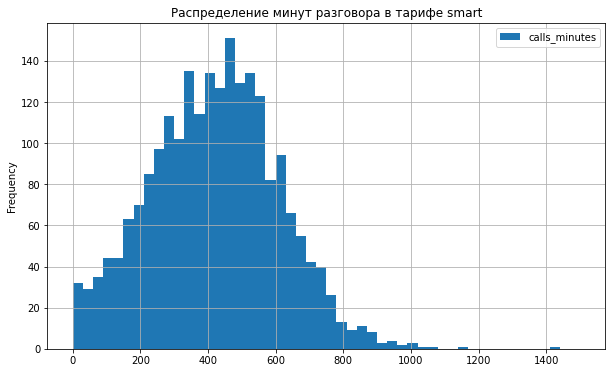

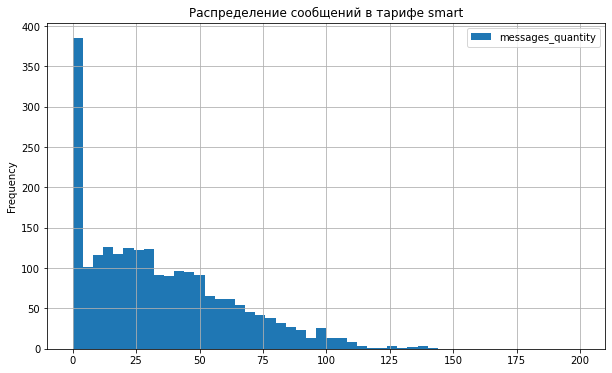

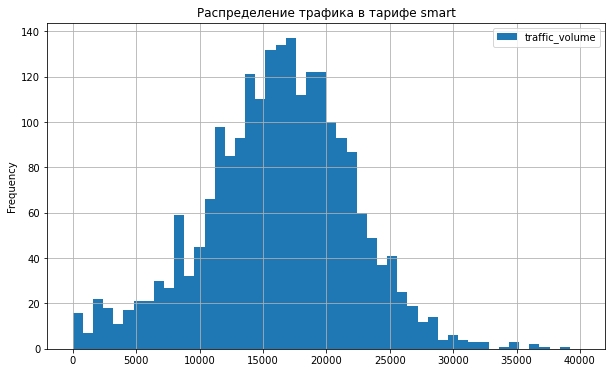

In [43]:
#строю гистограммы для минут разговора, сообщений и трафика для тарифа smart:

smart.plot(y='calls_minutes', kind='hist', bins=50, grid=True, figsize=(10,6), range=(0,1500))
plt.title('Распределение минут разговора в тарифе smart')
plt.show()

smart.plot(y='messages_quantity', kind='hist', bins=50, grid=True, figsize=(10,6), range=(0,200))
plt.title('Распределение сообщений в тарифе smart')
plt.show()

smart.plot(y='traffic_volume', kind='hist', bins=50, grid=True, figsize=(10,6), range=(0,40000))
plt.title('Распределение трафика в тарифе smart')
plt.show()

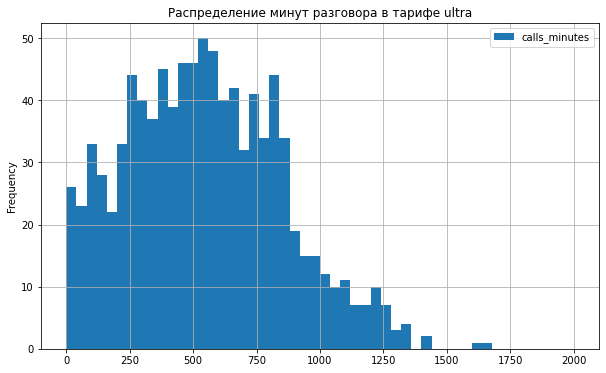

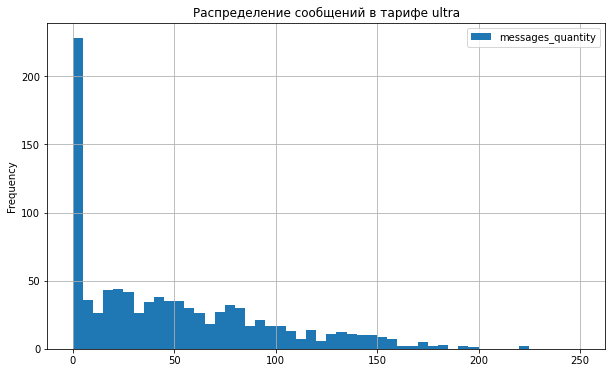

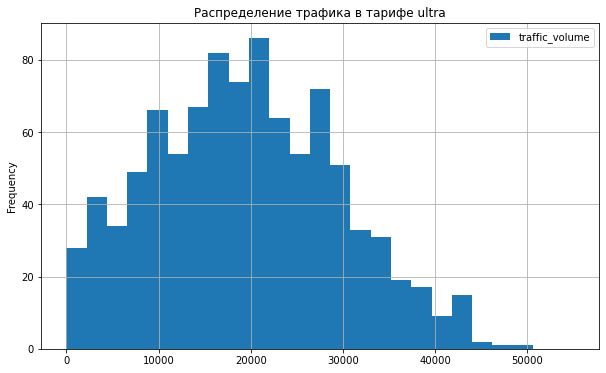

In [44]:
#строю гистограммы для минут разговора, сообщений и трафика для тарифа ultra:

ultra.plot(y='calls_minutes', kind='hist', bins=50, grid=True, figsize=(10,6), range=(0,2000))
plt.title('Распределение минут разговора в тарифе ultra')
plt.show()

ultra.plot(y='messages_quantity', kind='hist', bins=50, grid=True, figsize=(10,6), range=(0,250))
plt.title('Распределение сообщений в тарифе ultra')
plt.show()

ultra.plot(y='traffic_volume', kind='hist', bins=25, grid=True, figsize=(10,6), range=(0,55000))
plt.title('Распределение трафика в тарифе ultra')
plt.show()

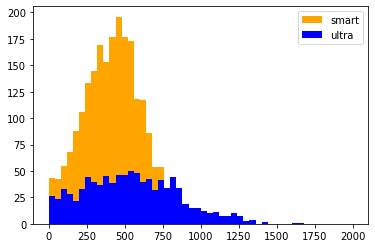

In [45]:
#для наглядности - два графика по каждой услуге:
y1 = smart['calls_minutes']
y2 = ultra['calls_minutes']

plt.hist(y1, bins=50, range=(0,2000), color='orange', label='smart')
plt.hist(y2, bins=50, range=(0,2000), color='blue', label='ultra')
plt.legend(loc='upper right')
plt.show()

In [46]:
#смотрю корреляции в тарифе smart:
smart[['calls_minutes', 'messages_quantity', 'traffic_volume', 'revenue']].corr()

,calls_minutes,messages_quantity,traffic_volume,revenue
calls_minutes,1.000000,0.203511,0.342513,0.416401
messages_quantity,0.203511,1.000000,0.146664,0.130352
traffic_volume,0.342513,0.146664,1.000000,0.847385
revenue,0.416401,0.130352,0.847385,1.000000


In [47]:
#смотрю корреляции в тарифе ultra:
ultra[['calls_minutes', 'messages_quantity', 'traffic_volume', 'revenue']].corr()

,calls_minutes,messages_quantity,traffic_volume,revenue
calls_minutes,1.000000,0.102207,0.190912,0.092462
messages_quantity,0.102207,1.000000,0.156863,0.017556
traffic_volume,0.190912,0.156863,1.000000,0.619621
revenue,0.092462,0.017556,0.619621,1.000000


### Выводы по п.3. Анализ данных:
1. Клиенты с тарифом smart потребляют в месяц:
- 230-608 минут разговора
- 5-61 сообщений
- 10347-22113 мб трафика 
<br>При этом компания выручает 474-2116р. с 1 клиента в месяц, в среднем 1295р., то есть клиенты исчерпывают лимиты пакета и берут доп.услуги.

2. Клиенты с тарифом ultra потребляют в месяц:
- 239-851 минуту разговора
- 5-95 сообщений
- 9345-29615 мб трафика 
<br>При этом компания выручает 1689-2453 руб. с 1 клиента в месяц, в среднем 2071р., то есть клиенты тоже исчерпывают лимиты пакета и берут доп.услуги, но не смски.

3. Судя по гистограммам тарифа smart:
- распределение звонков - нормальное со смещением вправо, чаще всего клиенты выбирают около 450 минут разговора, включенные в тарифный пакет
- гистограмма сообщений с всплеком на нуле, что означает, что большинство клиентов вообще не пользуются смсками 
- распределения трафика похоже на нормальное, чаще всего клиенты используют 16 Гб трафика, что больше на 1 Гб, чем в тарифном пакете, поэтому наибольшая корреляция - 0.8 - между трафиком и доходом.

4. Судя по гистограммам тарифа ultra:
- распределение звонков - нормальное со смещением вправо, чаще всего клиенты выбирают около 550 минут разговора
- как и в тарифе smart, гистограмма сообщений с большим всплеком на нуле, что означает, что большинство клиентов вообще не пользуются смсками 
- распределения трафика похоже на нормальное, чаще всего клиенты используют 20 Гб трафика, то есть не выбирают положенные по тарифному плану 30 Гб, поэтому ожидаемо, что корреляция между трафиком и доходом меньше, чем в тарифе smart - 0.6.

## 4. Проверка гипотез

### 4.1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

H₀ (нулевая гипотеза) - средние выручки по тарифам равны.
<br>H₁ (альтернативная двусторонняя гипотеза) - средние выручки по тарифам различаются.
<br>Alpha (критический уровень статистической значимости) - 0.01, что даст 99% вероятность правильности вывода

In [48]:
alpha = .01   #если p-value окажется меньше него - отвергнем гипотезу

#использую метод .st.ttest_ind для проверки гипотезы о равенстве среднего двух совокупностей:
results = st.ttest_ind(smart['revenue'], ultra['revenue'], equal_var=False) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 3.155173205867294e-245
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность случайного совпадения средних наших выборок очень мала, следовательно, H₀ отвергается, следовательно, H₁ не отвергается, следовательно, средние двух выборок не равны.

Более того, в п.3.2 я вычислила, что средняя выручка по тарифу smart - 1295.56р., а средняя выручка по тарифу ultra - 2071.92р.

За счет проверки подтверждено, что средние выручки существенно различаются. 

### 4.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

H₀ (нулевая гипотеза) - средняя выручка по Москве равна средней выручке по регионам.
<br>H₁ (альтернативная гипотеза) - средние выручки по Москве и регионам различаются.
<br>Alpha (критический уровень статистической значимости) - 0.01, что даст 99% вероятность правильности вывода

In [49]:
moscow_users = all_data.query('city == "Москва"') 
region_users = all_data.query('city != "Москва"') 

alpha = .01   #если p-value окажется меньше него - отвергнем гипотезу

#использую метод .st.ttest_ind для проверки гипотезы о равенстве среднего двух совокупностей:
results = st.ttest_ind(moscow_users['revenue'], region_users['revenue'], equal_var=False) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.44113705815091153
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность случайного совпадения средних наших выборок есть, следовательно, H₀ не отвергается, следовательно, средняя выручка по Москве может быть равна средней выручке по регионам.
Действительно, если воспользоваться методом .mean(), то средняя доходность по Москве - 1550.15р., по регионам - 1522.95р., то есть различие очень маленькое.

## 4. Общие выводы 
1. Изначально данные 5 датафреймов были объединены в один, при этом были заменены типы даныыех, обработаны пропуски, добавлены необходимые для анализа данные и убраны ненужные, в частности перс.данные клиентов.
2. Клиенты обоих тарифов очень часто не используют смс либо используют очень мало. При этом пользователи тарифа smart, в отличие от клиентов тарифа ultra, часто выходят из лимитов пакета по минутам и трафику. Пользователи тарифа ultra за пределы пакета чаще всего не выходят.
3. Больше всего дополнительного дохода компании приносит трафик, причем в обоих тарифах. С учетом того, что пользователей тарифа smart больше, общая прибыль по этому тарифу будет больше. 
4. Средняя выручка по тарифу ultra выше. Средняя выручка по Москве и средняя выручка по регионам правктически не различается.
5. С учетом того, что в тарифе smart - 349 клиентов, средняя выручка - 1291р., в тарифе ultra - 143 клиента, средняя выручка - 2071р., то более выгодный для компании тариф smart, так как он дает среднюю суммарную прибыль более 450 тыс.р. за счет более широкой базы. Для сравнения - тариф ultra дает 296 тыс.р., в основном эта прибыль за счет большей средней прибыльности, а не кол-ва абонентов.

<br>Таким образом, компании можно сосредоточиться на наращивании кол-ва клиентов обоих тарифов с приоритетом тарифа smart (например, в соотношение 60/40 в бюджетах продвижения в пользу тарифа smart) и вне зависимости от региона, если емкость рынка и конкуренция позволяют это сделать.